# CineBot


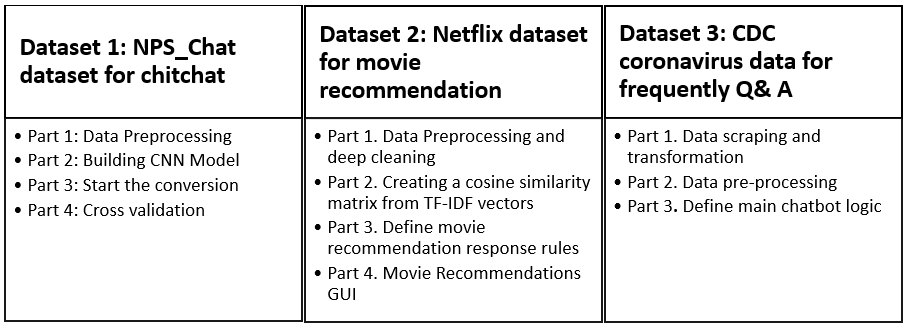


### Dataset 1: NPS_Chat dataset for Chitchat 

### Part 1: Data Preprocessing

In [ ]:
# Import libraries
import nltk
import numpy as np
import pandas as pd
import random
import json
import pickle
import string
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import nps_chat
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Print out all the tags offered by nps_chat
posts = nps_chat.xml_posts()

# Finding the dialogue tag for each post
d_tags = [t.attrib['class'] for t in posts]
all_tags = sorted(set(d_tags))
print(all_tags)

In [ ]:
# Transform nps_chat into dataframe format
data = []
for p in nps_chat.xml_posts():
    # filter out the user name info within text
    data.append({"class":p.get("class"), "text": ' '.join([l for l in p.text.split() if 'User' not in l])})

# Dataframe format is convient to observe and easy to transform into different format if needed
df = pd.DataFrame.from_dict(data)
df = df.groupby('class')['text'].apply(list).reset_index()
df = df.set_index("class") 

In [ ]:
# Hardcode output for each tags - nps_chat doesn't provide output info.
accept_outputs = ["ok", "Sure","of course","No problem","NP","Cool","Sounds Good","Yep","I'm down"]
bye_outputs = ["See you", "Bye","See ya","Take care","Have a good one","See you around"]
clarify_outputs = ["Yes", "Exactly","Correct","For sure","Yeah","Maybe","I guess"]
continuer_outputs = ["Go on", "Go ahead","I'm listening","Keep going","and ?","Really?","emmm","Interesting"]
emotion_outputs = ["Happy", "Laugh","LOL","LAMO","hahahaha","Sad","ughhhh","yessss","awwww","Sh*t","Damn it"]
emphasis_outputs = ["O M G!!!!","I think so", "I bet", "How come?","me too", "Agree", "I'm on","Sort of","Holly"]
greet_outputs = ["Hey", "Hi","Yo, bro","What's up"]
other_outputs = ["NA","I don't understand","I have no idea."]
reject_outputs = ["No", "Nope","noooooo","no war","stop","nah","i don't think so","hell no!","you bet"]
statement_outputs = ["okok", "Sure"]
system_outputs = ["IOS", "windows"]
nAnswer_outputs = ["no", "I'll pass","nah","not really","no thanks"]
whQuestion_outputs = ["Becasue..", "sure","you guess","huh?","let me think","I forget","I don't know"
                      ]
yAnswer_outputs = ["Yes", "go ahead","hell yeah","yep","yea","alright","I think so","I'm sorry, but yes","please"]
ynQuestion_outputs = ["no", "no way","i can't believe it","are you serious","seriously?","maybe","I'm not sure",
                     "I think so","what do you think?"]

In [ ]:
# Converting all available data into JSON format - tag, input and output.
training = {
    'intents':[
        {"tag":"Accept",
         "inputs":df.loc["Accept"][0],
         "outputs":accept_outputs},
        {"tag":"Bye",
         "inputs":df.loc["Bye"][0],
         "outputs":bye_outputs},
        {"tag":"Clarify",
         "inputs":df.loc["Clarify"][0],
         "outputs":clarify_outputs},
        {"tag":"Continuer",
         "inputs":df.loc["Continuer"][0],
         "outputs":continuer_outputs},
        {"tag":"Emotion",
         "inputs":df.loc["Emotion"][0],
         "outputs":emotion_outputs},
        {"tag":"Emphasis",
         "inputs":df.loc["Emphasis"][0],
         "outputs": emphasis_outputs},
        {"tag":"Greet",
         "inputs":df.loc["Greet"][0],
         "outputs": greet_outputs},
        {"tag":"Other",
         "inputs":df.loc["Other"][0],
         "outputs":other_outputs},
        {"tag":"Reject",
         "inputs":df.loc["Reject"][0],
         "outputs":reject_outputs},
        {"tag":"Statement",
         "inputs":df.loc["Statement"][0],
         "outputs":statement_outputs},
        {"tag":"System",
         "inputs":df.loc["System"][0],
         "outputs":system_outputs},
        {"tag":"nAnswer",
         "inputs":df.loc["nAnswer"][0],
         "outputs":nAnswer_outputs},
        {"tag":"whQuestion",
         "inputs":df.loc["whQuestion"][0],
         "outputs":whQuestion_outputs},
        {"tag":"yAnswer",
         "inputs":df.loc["yAnswer"][0],
         "outputs":yAnswer_outputs},
        {"tag":"ynQuestion",
         "inputs":df.loc["ynQuestion"][0],
         "outputs":ynQuestion_outputs}
    ]
}

In [ ]:
# Save the processed dataset into local and name it model_train.json
model_train = json.dumps(training, indent=2)
with open('model_train.json', 'w') as f:
    f.write(model_train + '\n')

## Part 2: Building the Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# Define further data processing functions
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return lemmatizer.lemmatize(word)

In [ ]:
# Further clean data and Create list of inputs and tags
patterns = []
tags = []
documents = []
ignore_words = nltk.word_tokenize(string.punctuation)

data_file = open('model_train.json').read()
intents = json.loads(data_file)

for intent in intents['intents']:
    if intent['tag'] not in tags:
        tags.append(intent['tag'])
    for pattern in intent['inputs']:
        w = tokenize(pattern)
        patterns.extend(w)
        documents.append((w,intent['tag']))       

patterns = [stem(w) for w in patterns if w not in ignore_words]
patterns = sorted(list(set(patterns)))
tags = sorted(list(set(tags)))

In [ ]:
# Use bag of words method to prepare training datasets
training = []
output_empty = np.zeros(len(tags), dtype = np.float32)
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [stem(word) for word in pattern_words]
    
    for pattern in patterns:
        bag.append(1) if pattern in pattern_words else bag.append(0)
    
    output_row = list(output_empty)
    output_row[tags.index(doc[1])] = 1
    training.append([bag,output_row])
    
random.shuffle(training)
training = np.array(training)

X_train = np.array(list(training[:,0]))
y_train = np.array(list(training[:,1]))

In [ ]:
# Build and train CNN model
model = Sequential(name='nn')
model.add(Dense(128, input_shape = (len(X_train[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train[0]), activation = 'softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss ='categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

# same as "model" just so it has a different name..
model2 = Sequential(name='nn2')
model2.add(Dense(128, input_shape = (len(X_train[0]),), activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(len(y_train[0]), activation = 'softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model2.compile(loss ='categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

hist = model.fit(X_train, y_train, epochs = 20, batch_size = 5, verbose = 1)

In [ ]:
# Model and data serialization
pickle.dump(patterns, open('patterns.pkl','wb'))
pickle.dump(tags, open('tags.pkl','wb'))
model.save('chatbot_model.h5', hist)

## Part 3: Start the conversion

In [ ]:
# Load the serialized data and model
from keras.models import load_model
model = load_model('chatbot_model.h5')

intents = json.loads(open('model_train.json').read())
patterns = pickle.load(open('patterns.pkl','rb'))
tags = pickle.load(open('tags.pkl','rb'))

In [ ]:
# Define function to process user inputs and chatbot respond rules
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

def bow(sentence, patterns, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = np.zeros(len(patterns), dtype = np.float32) 
    for s in sentence_words:
        for i,w in enumerate(patterns):
            if w == s: 
                bag[i] = 1 # assign 1 if current word is in the vocabulary position
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, patterns,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key = lambda x: x[1], reverse = True)
    return_list = []
    for r in results:
        return_list.append({"intent": tags[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['outputs'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res

In [ ]:
# Create GUI with tkinter and start a conversation
import tkinter
from tkinter import *

def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state = NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground = "#442265", font = ("Verdana", 12))
    
        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')
            
        ChatLog.config(state = DISABLED)
        ChatLog.yview(END)
 
base = Tk()
base.title("CineBot.0")
base.geometry("400x500")
base.resizable(width = FALSE, height = FALSE)

#Create Chat window
ChatLog = Text(base, bd = 0, bg = "white", height = "10", width = "60", font = "Arial",)

ChatLog.config(state = DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font = ("Verdana",12,'bold'), text = "Send", width = "12", height = 5,
                    bd = 0, bg = "#32de97", activebackground = "#3c9d9b",fg = '#ffffff',
                    command = send )

#Create the box to enter message
EntryBox = Text(base, bd = 0, bg = "white",width = "29", height = "5", font = "Arial")
#EntryBox.bind("<Return>", send)


#Place all components on the screen
scrollbar.place(x = 376,y = 6, height = 386)
ChatLog.place(x = 6,y = 6, height = 386, width = 370)
EntryBox.place(x = 128, y = 401, height = 90, width = 265)
SendButton.place(x = 6, y = 401, height = 90)

base.mainloop()

## Part 4: Cross validation

In [ ]:
# cross validation for model selection / hyperparameter tuning
from sklearn.model_selection import KFold
from keras.metrics import CategoricalAccuracy

# a list of models with model definition and hyperparameters
models = [{'model':model, 'batch_size':5, 'epochs':20},
          {'model':model2, 'batch_size':10, 'epochs':15}]

# k-fold cv
kf = KFold(n_splits=5)
ratio = 0.7
data = training.copy()
ins_size = int(len(data) * ratio)
ins, oos = data[:ins_size], data[ins_size:]

for train_index, test_index in kf.split(ins):
    X_train, X_test = list(data[train_index, 0]), list(data[test_index, 0])
    y_train, y_test = list(data[train_index, 1]), list(data[test_index, 1])
    for md in models:
        hist = md['model'].fit(np.array(X_train), np.array(y_train), epochs=md['epochs'], 
                               batch_size=md['batch_size'], verbose=0)
        if 'cv_pred' not in md.keys():
            md['cv_pred'] = np.zeros((len(ins), len(y_test[0])))
        md['cv_pred'][test_index] = md['model'].predict(X_test)

In [ ]:
def compute_metrics(y_true, y_pred):
    metrics = []
    for i in np.unique(y_true):
        tp = ((y_true == y_pred) & (y_true == i)).sum() * 1.0
        prec = tp / (y_pred == i).sum() if (y_pred == i).any() else np.nan
        rec = tp / (y_true == i).sum() if (y_true == i).any() else np.nan
        f1 = 2./(1./prec+1./rec) if prec >= 0 and rec >= 0 else np.nan
        w = (y_true == i).sum() / len(y_true)
        metrics.append([i, prec, rec, f1, w])
    metrics = pd.DataFrame(metrics, columns=['class', 'prec', 'rec', 'f1', 'w'])
    cols = ['prec', 'rec', 'f1']
    for c in cols:
        metrics['w_'+c] = metrics[c] * w
    stats = pd.concat([metrics[cols].mean(), metrics[['w_'+c for c in cols]].sum()])
    acc = (y_true == y_pred).sum() / len(y_true)
    stats.loc['acc'] = acc
    return stats

def get_cv_stats(models, ins=ins, oos=oos, show_oos=False):
    res = []
    for md in models:
        y_true = np.argmax(np.array(list(ins[:, 1])), axis=1)
        y_pred = np.argmax(md['cv_pred'], axis=1)
        metrics = compute_metrics(y_true, y_pred)
        metrics.index = ['cv_'+i for i in metrics.index]
        metrics.loc['model'] = md['model'].name
        if show_oos:
            y_true_oos = np.argmax(np.array(list(oos[:, 1])), axis=1)
            y_pred_oos = np.argmax(md['model'].predict(list(oos[:, 0])), axis=1)
            oos_metrics = compute_metrics(y_true_oos, y_pred_oos)
            oos_metrics.index = ['oos_'+i for i in oos_metrics.index]
            metrics = pd.concat([metrics, oos_metrics])
        res.append(metrics)
    res = pd.concat(res, axis=1).T
    return res[['model'] + [c for c in res.columns if c != 'model']]

get_cv_stats(models, show_oos=False)

In [ ]:
# oos results of the first model
y_true_oos = np.argmax(np.array(list(oos[:, 1])), axis=1)
y_pred_oos = np.argmax(model.predict(list(oos[:, 0])), axis=1)
oos_metrics = compute_metrics(y_true_oos, y_pred_oos)
oos_metrics.index = ['oos_'+i for i in oos_metrics.index]
oos_metrics

==========================================================================================

# Dataset 2: Netflix dataset for movie recommendation

### Part 1. Data Preprocessing and deep cleaning

In [ ]:
df = pd.read_csv("netflix_titles.csv", sep=",")
df = df[['type','title','director','cast','listed_in','description']]
# Dealing with Missing Values
df.dropna(inplace=True)
df = df.reset_index(drop=True)

#Data Cleaning And Text Preprocessing
#Preprocessing the raw text

#1.Removing URL
import re

def clean_url(description):
    return re.sub(r'http\S+','', description)
df['description'] = df['description'].apply(clean_url)

attributes = ['description','listed_in','director', 'cast','type']

#2. Removing all irrelevant characters (Numbers and Punctuation)
def clean_non_alphanumeric(text):
    return re.sub('[^a-zA-Z]',' ',text)

for at in attributes:
    df[at] = df[at].apply(clean_non_alphanumeric)

#3. Convert all characters into lowercase

def clean_lowercase(text):
    return str(text).lower()

for at in attributes:
    df[at] = df[at].apply(clean_lowercase)

In [ ]:
#Tokenization
from nltk.tokenize import word_tokenize

def clean_tokenization(text):
    return word_tokenize(text)

for at in attributes:
    df[at] = df[at].apply(clean_tokenization)

#removing stopwords

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def clean_stopwords(token):
    return [item for item in token if item not in stop_words]

df['description'] = df['description'].apply(clean_stopwords)

#Stemming

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def clean_stem(token):
    return [stemmer.stem(i) for i in token]

df['description'] = df['description'].apply(clean_stem)

#Lemmatization
lemma = WordNetLemmatizer()
def clean_lemmatization(token):
    return [lemma.lemmatize(word=w, pos='v') for w in token]
df['description'] = df['description'].apply(clean_lemmatization)

#Remove the words having length <=2

def clean_length(token):
    return [i for i in token if len(i) > 2]
df['description'] = df['description'].apply(clean_length)

#Convert the list of tokens into back to the string
def convert_to_string(text):
    return ' '.join(text)

for at in attributes:
    df[at] = df[at].apply(convert_to_string)
    
df['summary'] = df['description'].str.cat(df['listed_in'],sep = ' ')
df['summary'] = df['summary'].str.cat(df['director'],sep = ' ')
df['summary'] = df['summary'].str.cat(df['cast'],sep = ' ')
df['summary'] = df['summary'].str.cat(df['type'],sep = ' ')
df = df[['title','summary']]

### Part 2. Creating a cosine similarity matrix from TF-IDF vectors

In [ ]:
# Feature Extraction and BOW (Bag of Words Creation)
#1. Create Cosine Similarity Matrix

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
#import TfidfTransformer from sklearn.feature_extraction.text 

TfidfVec = TfidfVectorizer(ngram_range=(1,2))
#Convert the text to a matrix of TF-IDF features
tfidf = TfidfVec.fit_transform(df['summary'])
feature_names = TfidfVec.get_feature_names()

#Creating a cosine similarity matrix from TF-IDF vectors
cosine_sim = cosine_similarity(tfidf, tfidf)
cosine_sim

### Part 3. Define movie recommendation response rules

In [ ]:
def response(title):
    recommended_content_titles = [ ]
    content_titles = pd.Series(df['title'])
    try:
        content_index = content_titles[content_titles == title].index[0]
        similarity_scores_list = pd.Series(cosine_sim[content_index]).sort_values(ascending =False)
        similar_content_indices = list(similarity_scores_list.iloc[1:4].index)
    except IndexError as e:
        movieRecommendation = validation_accTrue
        return(f'No such content with title {title} on our Movie List. Please try Again.')
        
    print(f'You have watched {title}, You may like:')
    for content in similar_content_indices:
        recommended_content_titles.append(str(df['title'][content]).upper())
    movie_list = ', '.join(recommended_content_titles)
    return("My movie recommendations are " + movie_list)

### Part 4. Movie Recommendations GUI

In [ ]:
movieRecommendation = False

def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)
    global movieRecommendation
    
    if movieRecommendation:
        ChatLog.config(state = NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground = "#442265", font = ("Verdana", 12))
        
        movieRecommendation = False
        
        res = response(msg)
        ChatLog.insert(END, "Bot: " +res+ '\n\n')
        
        ChatLog.config(state = DISABLED)
        ChatLog.yview(END)
    
    elif msg == "Movie Recommendation":
        ChatLog.config(state = NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground = "#442265", font = ("Verdana", 12))
        
        res = "I will recommend movies that you would like! Please enter your favorite movie/season :)"
        ChatLog.insert(END, "Bot: " + res + '\n\n')
        movieRecommendation = True
        
        ChatLog.config(state = DISABLED)
        ChatLog.yview(END)

    elif msg != '':
        ChatLog.config(state = NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground = "#442265", font = ("Verdana", 12))
    
        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')
        movieRecommendation = False
            
        ChatLog.config(state = DISABLED)
        ChatLog.yview(END)

base = Tk()
base.title("CineBot.0")
base.geometry("400x500")
base.resizable(width = FALSE, height = FALSE)

#Create Chat window
ChatLog = Text(base, bd = 0, bg = "white", height = "10", width = "60", font = "Arial",)
ChatLog.config(state = NORMAL)
ChatLog.config(foreground = "#442265", font = ("Verdana", 12))
ChatLog.insert(END, "Bot: Hi, this is CineBot! \n\nPlease send 'Movie Recommendation' if you need recommendations. \n\n")
ChatLog.config(state = DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font = ("Verdana",12,'bold'), text = "Send", width = "12", height = 5,
                    bd = 0, bg = "#32de97", activebackground = "#3c9d9b",fg = '#ffffff',
                    command = send )

#Create the box to enter message
EntryBox = Text(base, bd = 0, bg = "white",width = "29", height = "5", font = "Arial")
#EntryBox.bind("<Return>", send)


#Place all components on the screen
scrollbar.place(x = 376,y = 6, height = 386)
ChatLog.place(x = 6,y = 6, height = 386, width = 370)
EntryBox.place(x = 128, y = 401, height = 90, width = 265)
SendButton.place(x = 6, y = 401, height = 90)

base.mainloop()

==========================================================================================

## Dataset 3: CDC coronavirus data for frequently Q& A

### Part 1. Data scraping and transformation

In [ ]:
from requests import get
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import nltk  
import random
import string
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import numpy  as np
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from chatterbot import ChatBot
from chatterbot.trainers import ChatterBotCorpusTrainer

# data scraping and transformation

url = 'https://www.cdc.gov/coronavirus/2019-ncov/faq.html'
response = get(url)

product = SoupStrainer(role=['tab','tabpanel'])
html_soup = BeautifulSoup(response.text, 'html.parser', parse_only=product)
type(html_soup)

BeautifulSoup

question = html_soup.find_all('span', role='heading')
answer = html_soup.find_all('div', attrs={'class':'card-body'})
question1 = []
answer1 = []
for q,a in zip(question, answer):
    question1.append(q.text.strip())
    answer1.append(a.text.strip())


coviddf = pd.DataFrame({'question': question1,'answer': answer1})
coviddf = coviddf.replace(['\n','\xa0','\r'], ' ',  regex = True)
coviddf.drop(coviddf.tail(4).index,
        inplace = True)
coviddf['question']= coviddf['question'].str.lower()
coviddf["question"] = coviddf['question'].str.replace('[^\w\s]','')

In [ ]:
coviddf.to_csv("data.csv", index = False)

### Part 2. Data pre-processing

In [ ]:
coviddf = pd.read_csv('data.csv')
COSINE_THRESHOLD = 0.65


# data pre-processing


def  clean(sentence):
    stemmer = LancasterStemmer()
    token = nltk.word_tokenize(sentence)
    stemm = [stemmer.stem(w) for w in token]
    return ' '.join(stemm)


#vectorirze the quetion set of the df


tfvec = TfidfVectorizer(min_df =1, stop_words = 'english')
questions = coviddf['question'].values
Q1 = []
for question in  questions:
    Q1.append(clean(question))
tfvec.fit(Q1)


# main chatbot logic 

def cosine_sim(inp):

    usr_vec = tfvec.transform([clean(inp.strip())])
    cos_sims = []

    for question in Q1:
        sims = cosine_similarity(tfvec.transform([question]), usr_vec)
        cos_sims.append(sims)

    ind = cos_sims.index(max(cos_sims))

    if max(cos_sims) >= COSINE_THRESHOLD:

        answer = coviddf['answer'][ind]

        return answer

### Part 3. Define main chatbot logic 

In [ ]:
import random
from random import choice
import json
import string
from model import chatbot_response
from movie_rec import response
from flask import Flask, request
import requests
from train import bottrained
from covid import cosine_sim
from twilio.twiml.messaging_response import MessagingResponse

movieRecommendation = False 

app = Flask(__name__)


@app.route('/bot', methods=['POST'])


def bot():


    # main chatbot logic 
    

    incoming_msg = request.values.get('Body', '').lower()
    resp = MessagingResponse()
    msg = resp.message()


    #check cosine similarity:

    if cosine_sim(incoming_msg) != None:
    
        msg.body(cosine_sim(incoming_msg))

    #recommend a movie
    else:
        global movieRecommendation
        if movieRecommendation:
            mov_resp = str(response(incoming_msg))
            msg.body(mov_resp)
            if 'No' and 'such' in mov_resp:
                movieRecommendation = True
            else:
                movieRecommendation =  False

        if 'famous' and 'quote' in incoming_msg:

        # return a quote
            r = requests.get('https://api.quotable.io/random')
            if r.status_code == 200:
                data = r.json()
                quote = f'{data["content"]} ({data["author"]})'
                msg.body(quote)
        # return a joke 

        elif 'joke' in incoming_msg:
            r = requests.get('https://official-joke-api.appspot.com/random_joke')
            if r.status_code == 200:
                data = r.json()
                joke = f'{data["setup"]} {data["punchline"]}'
                msg.body(joke)
        # cute dog pictures

        elif 'sad' in incoming_msg:
            r = requests.get('https://dog.ceo/api/breeds/image/random')
            if r.status_code == 200:
                data = r.json()
                image = f'{data["message"]}'
                msg.media(image)

        elif 'movie' in incoming_msg:
            msg.body('What movies have you recently enjoyed?')
            movieRecommendation = True

        else:     
            chitchat = str(chatbot_response(incoming_msg))
            msg.body(chitchat)
            
    return str(resp)